In [1]:
import pandas as pd
import sys
sys.path.insert(0, '/home/azamat/python/analytic/proj_news_viz/nlp/preprocessing')
import preprocessing_tools

In [2]:
data = pd.read_json('/home/azamat/Загрузки/all/train.json')

In [3]:
data['processed'] = data.text.apply(preprocessing_tools.lemmatization)
data.head()

,id,sentiment,text,processed
0,1945,negative,Досудебное расследование по факту покупки ЕНПФ...,"[досудебный, расследование, факт, покупка, енп..."
1,1957,negative,Медики рассказали о состоянии пострадавшего му...,"[медик, рассказать, состояние, пострадавший, м..."
2,1969,negative,"Прошел почти год, как железнодорожным оператор...","[пройти, год, железнодорожный, оператор, запре..."
3,1973,negative,По итогам 12 месяцев 2016 года на территории р...,"[итог, 12, месяц, 2016, год, территория, респу..."
4,1975,negative,Астана. 21 ноября. Kazakhstan Today - Агентств...,"[астан, 21, ноябрь, kazakhstan, today, агентст..."


In [4]:
def convert_label(sentiment):
    if sentiment == 'negative':
        return 0
    return 1

data['label'] = data.sentiment.apply(convert_label)

In [5]:
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Using TensorFlow backend.


In [6]:
import gensim
from gensim.models import Word2Vec
w2v_model = Word2Vec.load('w2v/news_model.w2v')

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.processed, data.label, test_size=0.2, random_state=2)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(data.processed)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [9]:
import numpy as np

DIM = w2v_model.vector_size 
embedding_matrix = np.zeros((NUM, DIM))
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

In [10]:
from keras.layers import Input
from keras.layers.embeddings import Embedding

news_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
news_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(news_input)

In [11]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(news_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[news_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 200)      20000000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 26, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 25, 1)        401         dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [12]:
from keras.callbacks import ModelCheckpoint
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_split=0.25)

Train on 4957 samples, validate on 1653 samples
Epoch 1/10
4957/4957 [==============================] - 21s 4ms/step - loss: 0.5906 - precision: 0.8411 - recall: 0.9220 - f1: 0.8771 - val_loss: 0.4149 - val_precision: 0.8549 - val_recall: 0.9671 - val_f1: 0.9064
Epoch 2/10
4957/4957 [==============================] - 18s 4ms/step - loss: 0.4504 - precision: 0.8487 - recall: 0.9510 - f1: 0.8951 - val_loss: 0.4064 - val_precision: 0.8767 - val_recall: 0.9358 - val_f1: 0.9043
Epoch 3/10
4957/4957 [==============================] - 18s 4ms/step - loss: 0.4220 - precision: 0.8562 - recall: 0.9593 - f1: 0.9031 - val_loss: 0.3787 - val_precision: 0.8620 - val_recall: 0.9690 - val_f1: 0.9116
Epoch 4/10
4957/4957 [==============================] - 18s 4ms/step - loss: 0.4012 - precision: 0.8576 - recall: 0.9626 - f1: 0.9058 - val_loss: 0.3712 - val_precision: 0.8687 - val_recall: 0.9582 - val_f1: 0.9103
Epoch 5/10
4957/4957 [==============================] - 18s 4ms/step - loss: 0.3690 - precis

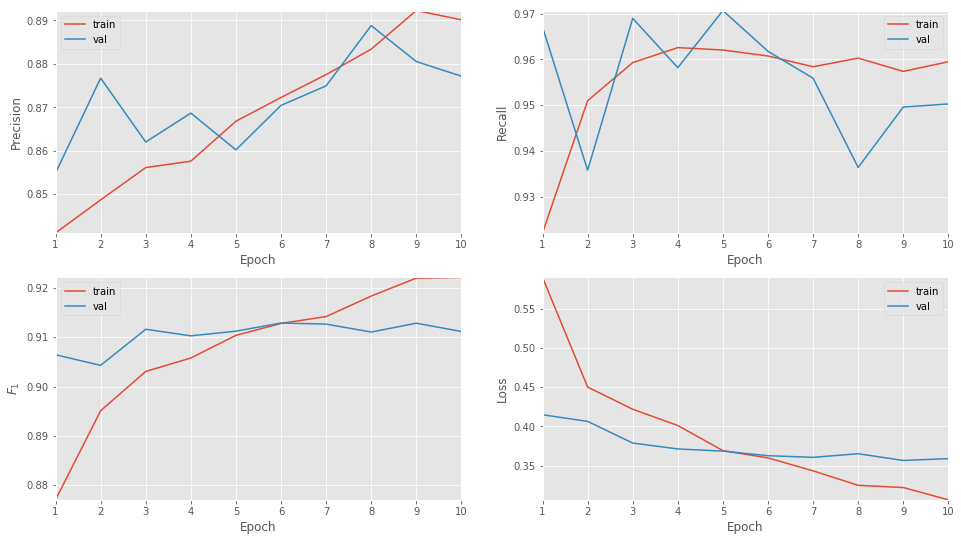

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)
plt.show()

In [16]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.64189   0.33333   0.43880       285
           1    0.87375   0.96126   0.91542      1368

   micro avg    0.85299   0.85299   0.85299      1653
   macro avg    0.75782   0.64730   0.67711      1653
weighted avg    0.83378   0.85299   0.83324      1653

